2024-10-11 23:40:43.304 | DEBUG    | pyrodigy.optimizer_wrapper:__init__:54 - Loading configuration for optimizer 'adabelief' with config 'high_memory'
2024-10-11 23:40:43.306 | DEBUG    | pyrodigy.optimizer_wrapper:load_config:122 - Configuration loaded: {'optimizer': 'AdaBelief', 'lr': 5e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01, 'weight_decouple': True, 'rectify': True, 'ams_bound': True, 'adanorm': True, 'r': 0.95}
2024-10-11 23:40:43.306 | DEBUG    | pyrodigy.optimizer_wrapper:get_optimizer_class:153 - Optimizer class 'AdaBelief' loaded for 'adabelief'
2024-10-11 23:40:43.307 | INFO     | pyrodigy.optimizer_wrapper:log_optimizer_details:175 - 
2024-10-11 23:40:43.307 | INFO     | pyrodigy.optimizer_wrapper:log_optimizer_details:176 - 🚀 Using PYRO's Optimizer Wrapper
2024-10-11 23:40:43.308 | INFO     | pyrodigy.optimizer_wrapper:log_optimizer_details:177 - 🔧 Optimizer Name: adabelief
2024-10-11 23:40:43.308 | INFO     | pyrodigy.optimizer_wrapper:log_optimizer

Epoch [1/20], d_loss: 1.8500, g_loss: 0.3800


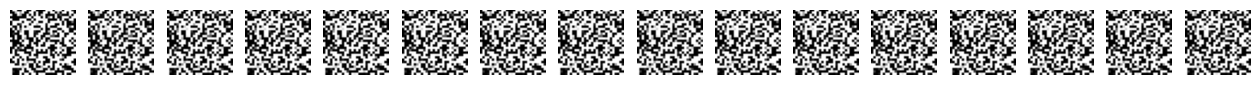

2024-10-11 23:40:56.239 | DEBUG    | pyrodigy.optimizer_wrapper:zero_grad:205 - Optimizer gradients zeroed.
2024-10-11 23:40:56.240 | DEBUG    | pyrodigy.optimizer_wrapper:step:193 - Optimizer step started.
2024-10-11 23:40:56.241 | DEBUG    | pyrodigy.optimizer_wrapper:step:195 - Optimizer step completed.
2024-10-11 23:40:56.242 | DEBUG    | pyrodigy.optimizer_wrapper:zero_grad:205 - Optimizer gradients zeroed.
2024-10-11 23:40:56.244 | DEBUG    | pyrodigy.optimizer_wrapper:step:193 - Optimizer step started.
2024-10-11 23:40:56.248 | DEBUG    | pyrodigy.optimizer_wrapper:step:195 - Optimizer step completed.
2024-10-11 23:40:56.254 | DEBUG    | pyrodigy.optimizer_wrapper:zero_grad:205 - Optimizer gradients zeroed.
2024-10-11 23:40:56.256 | DEBUG    | pyrodigy.optimizer_wrapper:step:193 - Optimizer step started.
2024-10-11 23:40:56.257 | DEBUG    | pyrodigy.optimizer_wrapper:step:195 - Optimizer step completed.
2024-10-11 23:40:56.258 | DEBUG    | pyrodigy.optimizer_wrapper:zero_grad:20

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pyrodigy.optimizer_wrapper import OptimizerWrapper

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
batch_size = 64
lr = 0.0002
epochs = 20


# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 28 * 28)
        return self.model(x)


# Transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

# Load the MNIST dataset
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Instantiate generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Define loss function
criterion = nn.BCELoss()

# Optimizers (replace Adam with any optimizer to test)
optimizer_G = OptimizerWrapper(generator.parameters(),"adabelief","high_memory") #optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = OptimizerWrapper(generator.parameters(),"adabelief","high_memory") #optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


# Function to display generated images
def show_images(generator):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        fake_images = generator(z).cpu().view(-1, 28, 28)
        fig, axes = plt.subplots(1, 16, figsize=(16, 1))
        for img, ax in zip(fake_images, axes):
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        plt.show()


# Training loop with image generation during training
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Train Discriminator
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator loss on real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        # Generate fake images and calculate discriminator loss on fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)

        # Generator loss - want discriminator to think these are real
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}"
    )

    # Generate and display images after every epoch
    show_images(generator)
